# Predict Pneumonia from x-ray scans
Made by
- Yannick K. Hartington

### Import Libraries

In [30]:
import datetime
import os
import random
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Layer, Input, Flatten, BatchNormalization, ReLU, Dropout, Dense, Conv2D, MaxPooling2D
from keras.models import Model
from keras import activations, regularizers, initializers, layers

In [31]:
tf.__version__

'2.15.0'

### Datasets
We will start out with inspecting the training set to see if it is proper balanced
#### Inspection of training set

In [32]:
dataset_path = r'/mnt/c/Datasets/Chest X-Ray Images/chest_xray' # WSL
#path_dataset = r'C:\Datasets\Chest X-Ray Images\chest_xray' # Windows

# Path to training dataset
train_path = os.path.join(dataset_path, 'train')

# Path to validation dataset
val_path = os.path.join(dataset_path, 'val')

# Path to test dataset
test_path = os.path.join(dataset_path, 'test')

In [33]:
normal_path = os.path.join(train_path, 'NORMAL')
pneumonia_path = os.path.join(train_path, 'PNEUMONIA')

normal_cases = [f for f in os.listdir(normal_path) if f.endswith('.jpeg')]
pneumonia_cases = [f for f in os.listdir(pneumonia_path) if f.endswith('.jpeg')]

In [34]:
training_cases = []
for image in normal_cases:
    training_cases.append((image, 0))

for image in pneumonia_cases:
    training_cases.append((image, 1))

We will take a quick look at how normal and pneumonia cases looks like in the training set

In [71]:
normal_images = random.sample(normal_cases,4)
pneumonia_images = random.sample(pneumonia_cases,4)

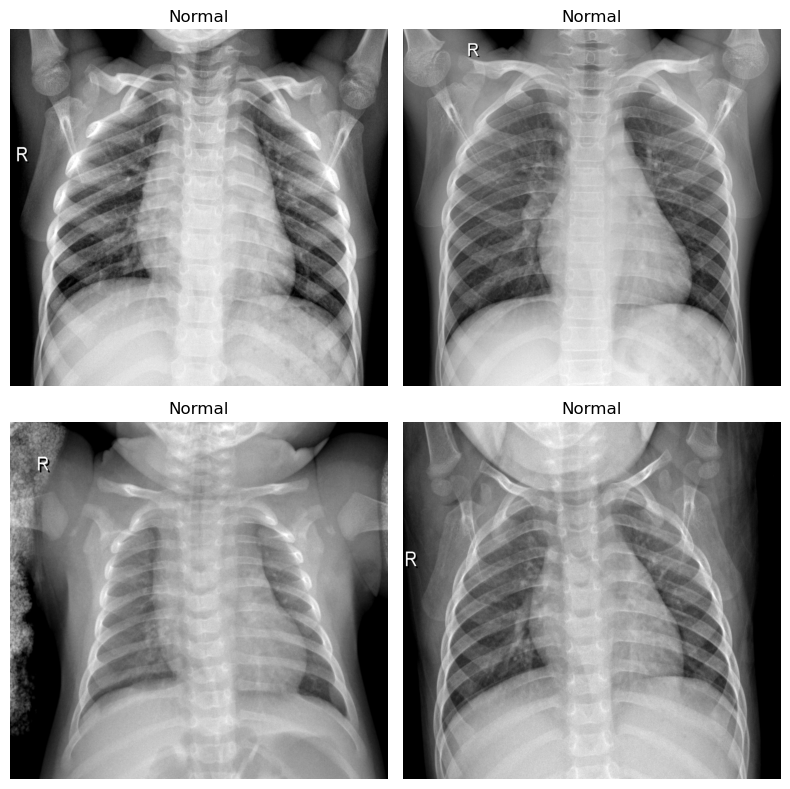

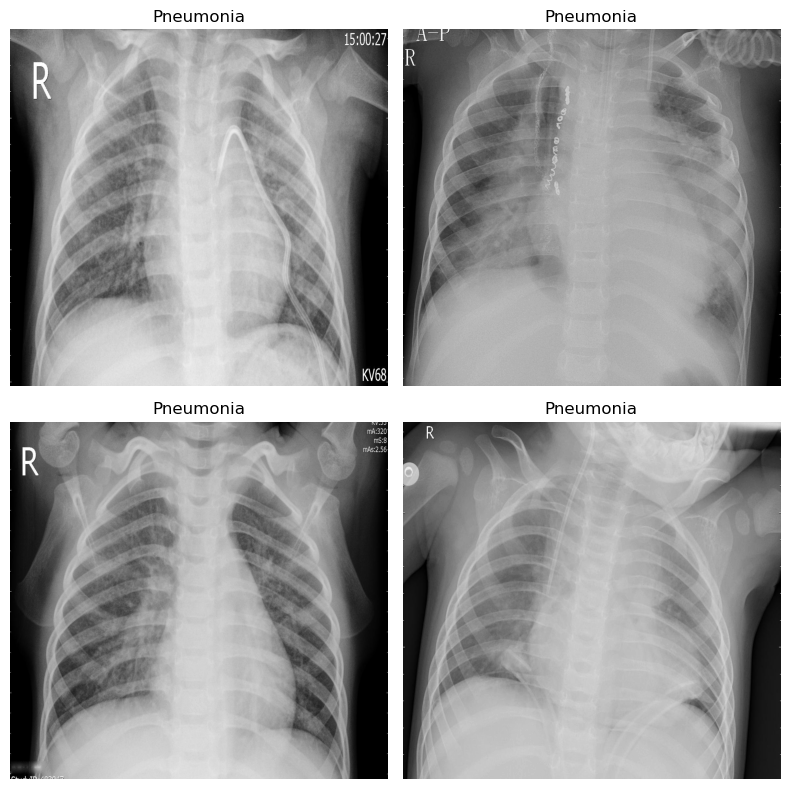

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(4):
    img = Image.open(normal_path + '/' + normal_images[i])
    axes[i//2, i%2].imshow(img, cmap='gray')
    axes[i//2, i%2].set_title("Normal")
    axes[i//2, i%2].axis('off')
    axes[i//2, i%2].set_aspect('auto')

# Adjust layout to prevent overlapping
plt.tight_layout() 
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(4):
    img = Image.open(pneumonia_path + '/' + pneumonia_images[i])
    axes[i//2, i%2].imshow(img, cmap='gray')
    axes[i//2, i%2].set_title("Pneumonia")
    axes[i//2, i%2].axis('off')
    axes[i//2, i%2].set_aspect('auto')

# Adjust layout to prevent overlapping
plt.tight_layout() 
plt.show()

In [35]:
training_data = pd.DataFrame(training_cases, columns=['Image', 'Label'])
training_data

,Image,Label
0,IM-0115-0001.jpeg,0
1,IM-0117-0001.jpeg,0
2,IM-0119-0001.jpeg,0
3,IM-0122-0001.jpeg,0
4,IM-0125-0001.jpeg,0
...,...,...
5211,person99_virus_183.jpeg,1
5212,person9_bacteria_38.jpeg,1
5213,person9_bacteria_39.jpeg,1
5214,person9_bacteria_40.jpeg,1


Label
1    3875
0    1341
Name: count, dtype: int64


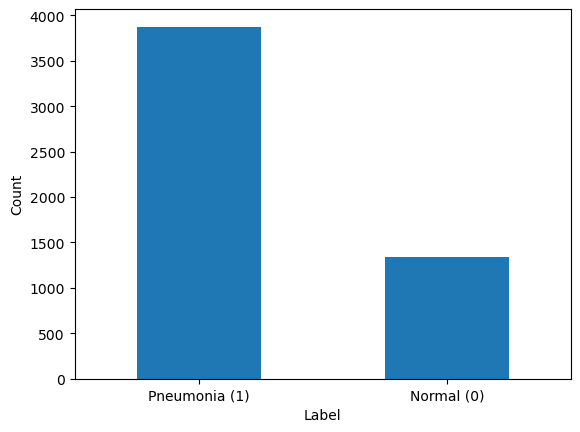

In [36]:
cases_count = training_data['Label'].value_counts()
ax = training_data['Label'].value_counts().plot(kind='bar', rot=0)
ax.set_xticks(range(len(cases_count.index)), ['Pneumonia (1)', 'Normal (0)'])
ax.set_ylabel('Count')
print(cases_count)

We can see that our training data is not balanced at all, with almost 3 times as many Pneumonia cases compared to normal cases. In a perfect world we would just collect some more data(normal cases), however, this is not possible here. Instead we will utilize Data Augmentation, which will increase the size of the training data by taking the original samples and transform them in different ways. 



#### Load datasets

In [8]:
target_size = (224, 224)
seed = 42
# Pixel values are typically between 0 and 255. We would like to have them between 0 and 1
rescaling = 1./255 

In [9]:
train_datagen = ImageDataGenerator(
    rescale=rescaling,
    rotation_range=10,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    )
train_generator = train_datagen.flow_from_directory(
    (dataset_path + '/train'),
    seed=seed,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    )

val_datagen = ImageDataGenerator(
    rescale=rescaling, 
)
validation_generator = val_datagen.flow_from_directory(
    (dataset_path + '/val'),
    seed=seed,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    )

test_datagen = ImageDataGenerator(
    rescale=rescaling, 
)
test_generator = test_datagen.flow_from_directory(
    (dataset_path + '/test'),
    seed=seed,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Found 624 images belonging to 2 classes.


## Model

In [25]:
inputs = Input((target_size[0], target_size[1], 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.4)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.3)(x)
x = Conv2D(64, (1, 7), activation='relu')(x)
x = Conv2D(64, (7, 1), activation='relu')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.4)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.4)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
#x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs, output)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_25 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_18 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 re_lu_15 (ReLU)             (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                     

#### Callbacks

In [26]:
monitor = 'val_accuracy'
checkpoint_filepath = r'./tmp/checkpoint'

In [27]:
# Callback to get the best weights 
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=monitor,
    mode='max',
    save_best_only=True)

In [28]:
# Callback to stop training when the model has not improved on the monitored metric for x number of epochs
early_stopping = keras.callbacks.EarlyStopping(
    monitor=monitor, 
    patience=15, 
    restore_best_weights=True)

In [29]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [30]:
callbacks = [model_checkpoint_callback, early_stopping, tensorboard_callback]

Vi skal have tensorboard med her så vi kan se træningen undervejs.

In [31]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    train_generator,
    batch_size=64, 
    epochs=100, 
    #verbose=2,
    validation_data = validation_generator, 
    callbacks=callbacks
    )

Epoch 1/100


2024-01-26 07:50:14.150886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


163/163 [==============================] - 77s 445ms/step - loss: 0.2832 - accuracy: 0.8815 - val_loss: 2.3290 - val_accuracy: 0.5000
Epoch 2/100
163/163 [==============================] - 71s 434ms/step - loss: 0.1819 - accuracy: 0.9293 - val_loss: 3.5294 - val_accuracy: 0.5000
Epoch 3/100
163/163 [==============================] - 72s 443ms/step - loss: 0.1521 - accuracy: 0.9398 - val_loss: 3.4029 - val_accuracy: 0.5000
Epoch 4/100
163/163 [==============================] - 75s 462ms/step - loss: 0.1281 - accuracy: 0.9544 - val_loss: 2.4137 - val_accuracy: 0.5000
Epoch 5/100
163/163 [==============================] - 72s 441ms/step - loss: 0.1082 - accuracy: 0.9574 - val_loss: 1.1772 - val_accuracy: 0.5625
Epoch 6/100
163/163 [==============================] - 71s 436ms/step - loss: 0.1164 - accuracy: 0.9540 - val_loss: 1.2319 - val_accuracy: 0.6250
Epoch 7/100
163/163 [==============================] - 71s 437ms/step - loss: 0.1051 - accuracy: 0.9597 - val_loss: 0.7554 - val_accurac

In [32]:
# The best weights are loaded into the model
model.load_weights(checkpoint_filepath)

In [33]:
# Save our best model
model.save('ModelChestXRay.h5')

/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### History of the training

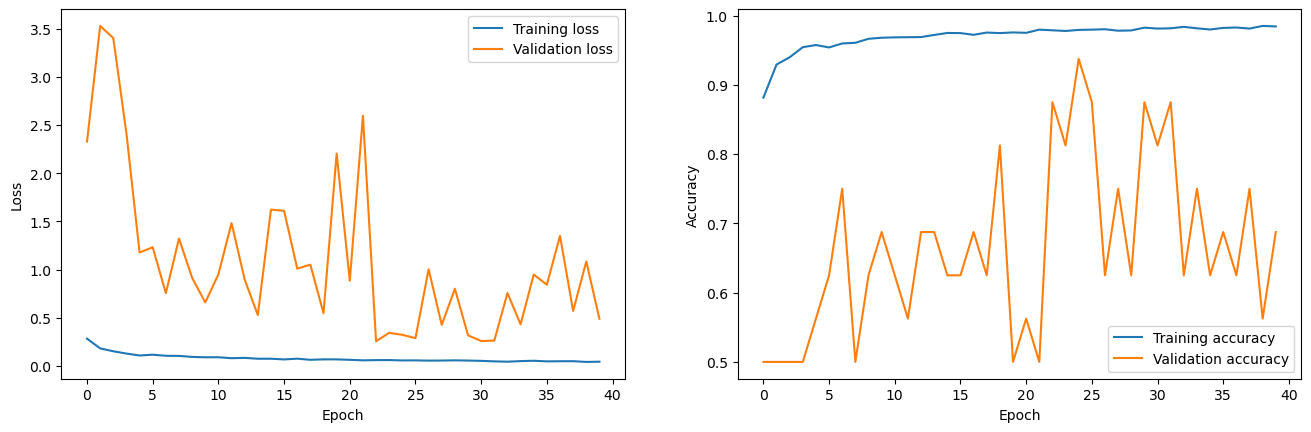

In [34]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Training accuracy')
ax.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Evaluate model on the test set

In [35]:
model.evaluate(test_generator)

20/20 [==============================] - 6s 309ms/step - loss: 0.9400 - accuracy: 0.7821


[0.9400439262390137, 0.7820512652397156]

## We would like to see, what the model is looking at to predict if the patient has pneumonia